## Session-based Recommendation
This notebook is based on the codebase provided by the authors of [this](https://arxiv.org/pdf/1803.09587.pdf) paper provided [here](https://www.dropbox.com/sh/dbzmtq4zhzbj5o9/AACldzQWbw-igKjcPTBI6ZPAa?dl=0). Authors of the paper have implemented a number of baseline algorithms and methods for session-based recommendation, and compared their performances with that of a number of SOTA session-based recommenders at the time and showed that these methods perform comparable to those methods. Although this paper dates back to 2018, the strong performance of these baselines can provide a good starting point for session-based use cases. In this notebook, we study three of these baselines on the retailrocket dataset. You can access more methods and datasets in the original paper's codebase.

Let's dive into the implementation.

In [ ]:
import time
import numpy as np
import pandas as pd
from math import log10
import collections as col

from datetime import datetime
from datetime import timedelta
from datetime import timezone
import os.path

First, we import the dataset.

In [ ]:
##Importing the data file from google drive

from google.colab import drive
drive.mount('/content/drive/')          # this will direct you to a link where you can get anmhkk authorization key
import sys
sys.path.append('/content/drive/My Drive/')
##Changing the working directory

%cd '/content/drive/My Drive/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [ ]:
%cd VectorProject/

/content/drive/My Drive/VectorProject


Preprocessing of the dataset is performed next. First, we define the configuration parameters for this pre-processings.

In [ ]:


#data config (all methods)
DATA_PATH = 'retailrocket/'
DATA_PATH_PROCESSED = 'retailrocket/prepared/'
DATA_FILE = 'events'
SESSION_LENGTH = 30 * 60 #30 minutes

#filtering config (all methods)
MIN_SESSION_LENGTH = 2
MIN_ITEM_SUPPORT = 5

#min date config
MIN_DATE = '2015-09-02'

#days test default config
DAYS_TEST = 2

#slicing default config
NUM_SLICES = 5
DAYS_OFFSET = 0 #offset in days from the first date in the data set
DAYS_SHIFT = 27 #number of days the training start date is shifted after creating one slice
DAYS_TRAIN = 25
DAYS_TEST = 2



First of all, we need to load data from the CSV file and perform several data preprocessing steps:

1- we load the data from the CSV file, specifying the columns and data types.
2- Name the columns 'Time', 'UserId', 'Type', and 'ItemId'.
3- Divide 'Time' column by 1000 to convert it to seconds.
4- Sort the data based on 'UserId' and 'Time' in ascending order.
5- Convert the 'Time' column to datetime format.
6- Sort the data again based on 'UserId' and 'TimeTmp' (converted time) in ascending order.
7- Calculate the time difference between consecutive rows and create a new column 'SessionIdTmp' indicating if a new session has started based on a predefined session length.
8- Assign a session ID to each row based on the 'SessionIdTmp' column, cumulatively summing the values.
9- Remove unnecessary columns and sort the data based on 'SessionId' and 'Time' in ascending order.
10- Separate the 'addtocart' events into a separate dataframe named 'cart'.
11- Remove rows with 'Type' other than 'view' from the main dataframe and delete the 'TimeTmp' column.

Finally, Return the preprocessed data and the 'cart' dataframe.


In [ ]:
def load_data( file ) :

    #load csv
    data = pd.read_csv( file+'.csv', sep=',', header=0, usecols=[0,1,2,3], dtype={0:np.int64, 1:np.int32, 2:str, 3:np.int32})

    #specify header names
    data.columns = ['Time','UserId','Type','ItemId']
    data['Time'] = (data.Time / 1000).astype( int )

    data.sort_values( ['UserId','Time'], ascending=True, inplace=True )

    #sessionize
    data['TimeTmp'] = pd.to_datetime(data.Time, unit='s')

    data.sort_values( ['UserId','TimeTmp'], ascending=True, inplace=True )
#     users = data.groupby('UserId')

    data['TimeShift'] = data['TimeTmp'].shift(1)

    data['TimeDiff'] = (data['TimeTmp'] - data['TimeShift']).dt.total_seconds().abs()
    print(12)
    data['SessionIdTmp'] = (data['TimeDiff'] > SESSION_LENGTH).astype( int )
    data['SessionId'] = data['SessionIdTmp'].cumsum( skipna=False )
    del data['SessionIdTmp'], data['TimeShift'], data['TimeDiff']


    data.sort_values( ['SessionId','Time'], ascending=True, inplace=True )

    cart = data[data.Type == 'addtocart']
    data = data[data.Type == 'view']
    del data['Type']

    print(data)

    #output

    print( data.Time.min() )
    print( data.Time.max() )
    data_start = datetime.fromtimestamp( data.Time.min(), timezone.utc )
    data_end = datetime.fromtimestamp( data.Time.max(), timezone.utc )

    del data['TimeTmp']

    print('Loaded data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
          format( len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat() ) )

    return data, cart;

Retrieve the minimum and maximum timestamps from the 'Time' column of the input data and convert them to datetime objects. Then, print information about the full dataset, including the slice ID, the number of events, sessions, unique items, and the time span of the data.

In [ ]:
def split_data_slice( data, output_file, slice_id, days_offset, days_train, days_test ) :

    data_start = datetime.fromtimestamp( data.Time.min(), timezone.utc )
    data_end = datetime.fromtimestamp( data.Time.max(), timezone.utc )

    print('Full data set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}'.
          format( slice_id, len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.isoformat(), data_end.isoformat() ) )


    start = datetime.fromtimestamp( data.Time.min(), timezone.utc ) + timedelta( days_offset )
    middle =  start + timedelta( days_train )
    end =  middle + timedelta( days_test )

    #prefilter the timespan
    session_max_times = data.groupby('SessionId').Time.max()
    greater_start = session_max_times[session_max_times >= start.timestamp()].index
    lower_end = session_max_times[session_max_times <= end.timestamp()].index
    data_filtered = data[np.in1d(data.SessionId, greater_start.intersection( lower_end ))]

    print('Slice data set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {} / {}'.
          format( slice_id, len(data_filtered), data_filtered.SessionId.nunique(), data_filtered.ItemId.nunique(), start.date().isoformat(), middle.date().isoformat(), end.date().isoformat() ) )

    #split to train and test
    session_max_times = data_filtered.groupby('SessionId').Time.max()
    sessions_train = session_max_times[session_max_times < middle.timestamp()].index
    sessions_test = session_max_times[session_max_times >= middle.timestamp()].index

    train = data[np.in1d(data.SessionId, sessions_train)]

    print('Train set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}'.
          format( slice_id, len(train), train.SessionId.nunique(), train.ItemId.nunique(), start.date().isoformat(), middle.date().isoformat() ) )

    train.to_csv(output_file + '_train_full.'+str(slice_id)+'.txt', sep='\t', index=False)

    test = data[np.in1d(data.SessionId, sessions_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]

    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]

    print('Test set {}\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {} \n\n'.
          format( slice_id, len(test), test.SessionId.nunique(), test.ItemId.nunique(), middle.date().isoformat(), end.date().isoformat() ) )

    test.to_csv(output_file + '_test.'+str(slice_id)+'.txt', sep='\t', index=False)



This function is responsible for filtering the data based on specific criteria such as minimum item support and minimum session length. Here's a breakdown of what the function does:

1. Compute the session lengths by grouping the data by 'SessionId' and calculating the size of each group.
2. Filter out sessions that have only one event by selecting the rows where the 'SessionId' is present in the indices of session lengths greater than 1.
3. Compute the item supports by grouping the data by 'ItemId' and calculating the size of each group.
4. Filter out items that have item support less than the specified minimum item support by selecting the rows where the 'ItemId' is present in the indices of item supports greater than or equal to the minimum item support.
5. Recompute the session lengths after the previous filtering step.
6. Filter out sessions that have session lengths less than the specified minimum session length by selecting the rows where the 'SessionId' is present in the indices of session lengths greater than or equal to the minimum session length.
7. Print information about the filtered dataset, including the number of events, sessions, unique items, and the time span covered by the data.
After these, we divide the input data into slices, where each slice represents a subset of the data for training and testing purposes. The split_data_slice function is called within the loop to handle the actual splitting of the data for each slice.

In [ ]:
def filter_data( data, min_item_support, min_session_length ) :

    #y?
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[ session_lengths>1 ].index)]

    #filter item support
    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[ item_supports>= min_item_support ].index)]

    #filter session length
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[ session_lengths>= min_session_length ].index)]

    #output
    data_start = datetime.fromtimestamp( data.Time.min(), timezone.utc )
    data_end = datetime.fromtimestamp( data.Time.max(), timezone.utc )

    print('Filtered data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n\n'.
          format( len(data), data.SessionId.nunique(), data.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat() ) )

    return data;



def slice_data( data, output_file, num_slices, days_offset, days_shift, days_train, days_test ):

    for slice_id in range( 0, num_slices ) :
        split_data_slice( data, output_file, slice_id, days_offset+(slice_id*days_shift), days_train, days_test )

Using the functions explained above to load, filter, and slice the dataset. You can view the statistics of each slice printed out.


In [ ]:
def preprocess_slices( path=DATA_PATH, file=DATA_FILE, path_proc=DATA_PATH_PROCESSED, min_item_support=MIN_ITEM_SUPPORT, min_session_length=MIN_SESSION_LENGTH,
                       num_slices = NUM_SLICES, days_offset = DAYS_OFFSET, days_shift = DAYS_SHIFT, days_train = DAYS_TRAIN, days_test=DAYS_TEST ):

    data, buys = load_data( path+file )

    data = filter_data( data, min_item_support, min_session_length )
    slice_data( data, path_proc+file, num_slices, days_offset, days_shift, days_train, days_test )


In [ ]:
preprocess_slices()

12
               Time   UserId  ItemId             TimeTmp  SessionId
1361687  1442004589        0  285930 2015-09-11 20:49:49          0
1367212  1442004759        0  357564 2015-09-11 20:52:39          0
1367342  1442004917        0   67045 2015-09-11 20:55:17          0
830385   1439487966        1   72028 2015-08-13 17:46:06          1
742616   1438969904        2  325215 2015-08-07 17:51:44          2
...             ...      ...     ...                 ...        ...
206556   1433972768  1407575  121220 2015-06-10 21:46:08    1761093
47311    1433343689  1407576  356208 2015-06-03 15:01:29    1761094
1762583  1431899284  1407577  427784 2015-05-17 21:48:04    1761095
1744277  1431825683  1407578  188736 2015-05-17 01:21:23    1761096
482559   1435184526  1407579    2521 2015-06-24 22:22:06    1761097

[2664312 rows x 5 columns]
1430622011
1442545187
Loaded data set
	Events: 2664312
	Sessions: 1755206
	Items: 234838
	Span: 2015-05-03 / 2015-09-18


Filtered data set
	Events: 1085

In [ ]:



def load_data_exec( path, file, rows_train=None, rows_test=None, slice_num=None, density=1, train_eval=False ):
    '''
    Loads a tuple of training and test set with the given parameters.

    Parameters
    --------
    path : string
        Base path to look in for the prepared data files
    file : string
        Prefix of  the dataset you want to use.
        "yoochoose-clicks-full" loads yoochoose-clicks-full_train_full.txt and yoochoose-clicks-full_test.txt
    rows_train : int or None
        Number of rows to load from the training set file.
        This option will automatically filter the test set to only retain items included in the training set.
    rows_test : int or None
        Number of rows to load from the test set file.
    slice_num :
        Adds a slice index to the constructed file_path
        yoochoose-clicks-full_train_full.0.txt
    density : float
        Percentage of the sessions to randomly retain from the original data (0-1).
        The result is cached for the execution of multiple experiments.
    Returns
    --------
    out : tuple of pandas.DataFrame
        (train, test)

    '''

    print('START load data')
    st = time.time()
    sc = time.process_time()

    split = ''
    if( slice_num != None and isinstance(slice_num, int ) ):
        split = '.'+str(slice_num)

    train_appendix = '_train_full'
    test_appendix = '_test'
    if train_eval:
        train_appendix = '_train_tr'
        test_appendix = '_train_valid'

    density_appendix = ''
    if( density < 1 ): #create sample

        if not os.path.isfile( path + file + train_appendix + split + '.txt.'+str( density ) ) :

            train = pd.read_csv(path + file + train_appendix + split + '.txt', sep='\t', dtype={'ItemId':np.int64})
            test = pd.read_csv(path + file + test_appendix + split + '.txt', sep='\t', dtype={'ItemId':np.int64} )

            sessions = train.SessionId.unique()
            drop_n = round( len(sessions) - (len(sessions) * density) )
            drop_sessions = np.random.choice(sessions, drop_n, replace=False)
            train = train[ ~train.SessionId.isin( drop_sessions ) ]
            train.to_csv( path + file + train_appendix +split+'.txt.'+str(density), sep='\t', index=False )

            sessions = test.SessionId.unique()
            drop_n = round( len(sessions) - (len(sessions) * density) )
            drop_sessions = np.random.choice(sessions, drop_n, replace=False)
            test = test[ ~test.SessionId.isin( drop_sessions ) ]
            test = test[np.in1d(test.ItemId, train.ItemId)]
            test.to_csv( path + file + test_appendix +split+'.txt.'+str(density), sep='\t', index=False )

        density_appendix = '.'+str(density)

    if( rows_train == None ):
        train = pd.read_csv(path + file + train_appendix +split+'.txt'+density_appendix, sep='\t', dtype={'ItemId':np.int64})
    else:
        train = pd.read_csv(path + file + train_appendix +split+'.txt'+density_appendix, sep='\t', dtype={'ItemId':np.int64}, nrows=rows_train)
        session_lengths = train.groupby('SessionId').size()
        train = train[np.in1d(train.SessionId, session_lengths[ session_lengths>1 ].index)]

    if( rows_test == None ):
        test = pd.read_csv(path + file + test_appendix +split+'.txt'+density_appendix, sep='\t', dtype={'ItemId':np.int64} )
    else :
        test = pd.read_csv(path + file + test_appendix +split+'.txt'+density_appendix, sep='\t', dtype={'ItemId':np.int64}, nrows=rows_test )
        session_lengths = test.groupby('SessionId').size()
        test = test[np.in1d(test.SessionId, session_lengths[ session_lengths>1 ].index)]

#     rows_train = 10000
#     train = train.tail(10000)

    if( rows_train != None ):
        test = test[np.in1d(test.ItemId, train.ItemId)]
        session_lengths = test.groupby('SessionId').size()
        test = test[np.in1d(test.SessionId, session_lengths[ session_lengths>1 ].index)]

    #output
    data_start = datetime.fromtimestamp( train.Time.min(), timezone.utc )
    data_end = datetime.fromtimestamp( train.Time.max(), timezone.utc )

    print('Loaded train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n'.
          format( len(train), train.SessionId.nunique(), train.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat() ) )

    data_start = datetime.fromtimestamp( test.Time.min(), timezone.utc )
    data_end = datetime.fromtimestamp( test.Time.max(), timezone.utc )

    print('Loaded test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}\n\tSpan: {} / {}\n'.
          format( len(test), test.SessionId.nunique(), test.ItemId.nunique(), data_start.date().isoformat(), data_end.date().isoformat() ) )

    print( 'END load data ', (time.process_time()-sc), 'c / ', (time.time()-st), 's' )

    return (train, test)

## Defining Evaluation Metrics

Here, we use MRR, hit rate and precision metrics, but in the paper and its paper, there are more metrics that you can study on your own by copy and pasting the definition of the metrics from the 'evaluation' folder here.

In [ ]:
class MRR:
    '''
    MRR( length=20 )

    Used to iteratively calculate the average mean reciprocal rank for a result list with the defined length.

    Parameters
    -----------
    length : int
        MRR@length
    '''
    def __init__(self, length=20):
        self.length = length;

    def init(self, train):
        '''
        Do initialization work here.

        Parameters
        --------
        train: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        '''
        return

    def reset(self):
        '''
        Reset for usage in multiple evaluations
        '''
        self.test=0;
        self.pos=0

        self.test_popbin = {}
        self.pos_popbin = {}

        self.test_position = {}
        self.pos_position = {}

    def skip(self, for_item = 0, session = -1 ):
        pass

    def add(self, result, next_item, for_item=0, session=0, pop_bin=None, position=None ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        res = result[:self.length]

        self.test += 1

        if pop_bin is not None:
            if pop_bin not in self.test_popbin:
                self.test_popbin[pop_bin] = 0
                self.pos_popbin[pop_bin] = 0
            self.test_popbin[pop_bin] += 1

        if position is not None:
            if position not in self.test_position:
                self.test_position[position] = 0
                self.pos_position[position] = 0
            self.test_position[position] += 1

        if next_item in res.index:
            rank = res.index.get_loc( next_item )+1
            self.pos += ( 1.0/rank )

            if pop_bin is not None:
                self.pos_popbin[pop_bin] += ( 1.0/rank )

            if position is not None:
                self.pos_position[position] += ( 1.0/rank )



    def add_batch(self, result, next_item):
        '''
        Update the metric with a result set and the correct next item.

        Parameters
        --------
        result: pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        next_item: Array of correct next items
        '''
        i=0
        for part, series in result.iteritems():
            result.sort_values( part, ascending=False, inplace=True )
            self.add( series, next_item[i] )
            i += 1

    def result(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        return ("MRR@" + str(self.length) + ": "), (self.pos/self.test), self.result_pop_bin(), self.result_position()

    def result_pop_bin(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        csv = ''
        csv += 'Bin: ;'
        for key in self.test_popbin:
            csv += str(key) + ';'
        csv += '\nPrecision@' + str(self.length) + ': ;'
        for key in self.test_popbin:
            csv += str( self.pos_popbin[key] / self.test_popbin[key] ) + ';'

        return csv

    def result_position(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        csv = ''
        csv += 'Pos: ;'
        for key in self.test_position:
            csv += str(key) + ';'
        csv += '\nPrecision@' + str(self.length) + ': ;'
        for key in self.test_position:
            csv += str( self.pos_position[key] / self.test_position[key] ) + ';'

        return csv

class HitRate:
    '''
    MRR( length=20 )

    Used to iteratively calculate the average hit rate for a result list with the defined length.

    Parameters
    -----------
    length : int
        HitRate@length
    '''

    def __init__(self, length=20):
        self.length = length;

    def init(self, train):
        '''
        Do initialization work here.

        Parameters
        --------
        train: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        '''
        return

    def reset(self):
        '''
        Reset for usage in multiple evaluations
        '''
        self.test=0;
        self.hit=0

        self.test_popbin = {}
        self.hit_popbin = {}

        self.test_position = {}
        self.hit_position = {}

    def add(self, result, next_item, for_item=0, session=0, pop_bin=None, position=None):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''

        self.test += 1

        if pop_bin is not None:
            if pop_bin not in self.test_popbin:
                self.test_popbin[pop_bin] = 0
                self.hit_popbin[pop_bin] = 0
            self.test_popbin[pop_bin] += 1

        if position is not None:
            if position not in self.test_position:
                self.test_position[position] = 0
                self.hit_position[position] = 0
            self.test_position[position] += 1

        if next_item in result[:self.length].index:
            self.hit += 1

            if pop_bin is not None:
                self.hit_popbin[pop_bin] += 1

            if position is not None:
                self.hit_position[position] += 1



    def add_batch(self, result, next_item):
        '''
        Update the metric with a result set and the correct next item.

        Parameters
        --------
        result: pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        next_item: Array of correct next items
        '''
        i=0
        for part, series in result.iteritems():
            result.sort_values( part, ascending=False, inplace=True )
            self.add( series, next_item[i] )
            i += 1

    def result(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        return ("HitRate@" + str(self.length) + ": "), (self.hit/self.test), self.result_pop_bin(), self.result_position()


    def result_pop_bin(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        csv = ''
        csv += 'Bin: ;'
        for key in self.test_popbin:
            csv += str(key) + ';'
        csv += '\nHitRate@' + str(self.length) + ': ;'
        for key in self.test_popbin:
            csv += str( self.hit_popbin[key] / self.test_popbin[key] ) + ';'

        return csv

    def result_position(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        csv = ''
        csv += 'Pos: ;'
        for key in self.test_position:
            csv += str(key) + ';'
        csv += '\nHitRate@' + str(self.length) + ': ;'
        for key in self.test_position:
            csv += str( self.hit_position[key] / self.test_position[key] ) + ';'

        return csv

class Precision:
    '''
    Precision( length=20 )

    Used to iteratively calculate the average hit rate for a result list with the defined length.

    Parameters
    -----------
    length : int
        HitRate@length
    '''

    def __init__(self, length=20):
        self.length = length;

    def init(self, train):
        '''
        Do initialization work here.

        Parameters
        --------
        train: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        '''
        return

    def reset(self):
        '''
        Reset for usage in multiple evaluations
        '''
        self.test=0;
        self.hit=0

    def add(self, result, next_item, for_item=0, session=0, pop_bin=None, position=None):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        self.test += self.length
        self.hit += len( set(next_item) & set(result[:self.length].index) )

    def add_set(self, result, next_items, for_item=0, session=0):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        self.test += 1
        self.hit += len( set(next_items) & set(result[:self.length].index) ) / self.length

    def add_batch(self, result, next_item):
        '''
        Update the metric with a result set and the correct next item.

        Parameters
        --------
        result: pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        next_item: Array of correct next items
        '''
        i=0
        for part, series in result.iteritems():
            result.sort_values( part, ascending=False, inplace=True )
            self.add( series, next_item[i] )
            i += 1

    def result(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        return ("Precision@" + str(self.length) + ": "), (self.hit/self.test)

class Recall:
    '''
    Precision( length=20 )

    Used to iteratively calculate the average hit rate for a result list with the defined length.

    Parameters
    -----------
    length : int
        HitRate@length
    '''

    def __init__(self, length=20):
        self.length = length;

    def init(self, train):
        '''
        Do initialization work here.

        Parameters
        --------
        train: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        '''
        return

    def reset(self):
        '''
        Reset for usage in multiple evaluations
        '''
        self.test=0;
        self.hit=0

    def add(self, result, next_item, for_item=0, session=0, pop_bin=None, position=None):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        self.test += 1
        self.hit += len( set(next_item) & set(result[:self.length].index) )

    def add_set(self, result, next_items, for_item=0, session=0):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        self.test += 1
        self.hit += len( set(next_items) & set(result[:self.length].index) ) / len(next_items)

    def add_batch(self, result, next_item):
        '''
        Update the metric with a result set and the correct next item.

        Parameters
        --------
        result: pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        next_item: Array of correct next items
        '''
        i=0
        for part, series in result.iteritems():
            result.sort_values( part, ascending=False, inplace=True )
            self.add( series, next_item[i] )
            i += 1

    def result(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        return ("Recall@" + str(self.length) + ": "), (self.hit/self.test)

class MAP:
    '''
    MAP( length=20 )

    Used to iteratively calculate the mean average precision for a result list with the defined length.

    Parameters
    -----------
    length : int
        MAP@length
    '''
    def __init__(self, length=20):
        self.length = length;

    def init(self, train):
        '''
        Do initialization work here.

        Parameters
        --------
        train: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
        '''
        return

    def reset(self):
        '''
        Reset for usage in multiple evaluations
        '''
        self.test=0;
        self.pos=0

    def skip(self, for_item = 0, session = -1 ):
        pass

    def add_set(self, result, next_items, for_item=0, session=0 ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''

        last_recall = 0

        res = 0

        for i in range(self.length):
            recall = self.recall(result[:i].index, next_items)
            precision = self.precision(result[:i].index, next_items)
            res += precision * (recall - last_recall)
            last_recall = recall

        self.pos += res
        self.test += 1

    def add(self, result, next_item, for_item=0, session=0, pop_bin=None, position=None ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''

        sum = 0

        for i in range(self.length):
            sum += self.mrr(result, next_item, i+1)

        self.pos += ( sum / self.length )
        self.test += 1

    def recall( self, result, next_items ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''

        return len( set(next_items) & set(result) ) / len( next_items )

    def precision( self, result, next_items ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''

        return len( set(next_items) & set(result) ) / self.length

    def mrr( self, result, next_item, n ):
        '''
        Update the metric with a result set and the correct next item.
        Result must be sorted correctly.

        Parameters
        --------
        result: pandas.Series
            Series of scores with the item id as the index
        '''
        res = result[:n]

        if next_item in res.index:
            rank = res.index.get_loc( next_item )+1
            return 1.0/rank
        else:
            return 0

    def add_batch(self, result, next_item):
        '''
        Update the metric with a result set and the correct next item.

        Parameters
        --------
        result: pandas.DataFrame
            Prediction scores for selected items for every event of the batch.
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        next_item: Array of correct next items
        '''
        i=0
        for part, series in result.iteritems():
            result.sort_values( part, ascending=False, inplace=True )
            self.add( series, next_item[i] )
            i += 1

    def result(self):
        '''
        Return a tuple of a description string and the current averaged value
        '''
        return ("MAP@" + str(self.length) + ": "), (self.pos/self.test)


In [ ]:
data_path = 'retailrocket/prepared/'
file_prefix = 'events'
limit_train = None #limit in number of rows or None
limit_test = None #limit in number of rows or None
density_value = 1 #randomly filter out events (0.0-1.0, 1:keep all)
remove_imdups = False

export_csv = 'results/test-results.csv'

print( data_path )

# create a list of metric classes to be evaluated
metric = []
metric.append( HitRate(20) )
metric.append( HitRate(10) )
metric.append( HitRate(5) )
metric.append( HitRate(3) )
metric.append( MRR(20) )
metric.append( MRR(10) )
metric.append( MRR(5) )
metric.append( MRR(3) )

retailrocket/prepared/


In [ ]:
def evaluate_sessions(pr, metrics, test_data, train_data, items=None, cut_off=20, session_key='SessionId', item_key='ItemId', time_key='Time'):
    '''
    Evaluates the baselines wrt. recommendation accuracy measured by recall@N and MRR@N. Has no batch evaluation capabilities. Breaks up ties.

    Parameters
    --------
    pr : baseline predictor
        A trained instance of a baseline predictor.
    metrics : list
        A list of metric classes providing the proper methods
    test_data : pandas.DataFrame
        Test data. It contains the transactions of the test set.It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
        It must have a header. Column names are arbitrary, but must correspond to the keys you use in this function.
    train_data : pandas.DataFrame
        Training data. Only required for selecting the set of item IDs of the training set.
    items : 1D list or None
        The list of item ID that you want to compare the score of the relevant item to. If None, all items of the training set are used. Default value is None.
    cut-off : int
        Cut-off value (i.e. the length of the recommendation list; N for recall@N and MRR@N). Defauld value is 20.
    session_key : string
        Header of the session ID column in the input file (default: 'SessionId')
    item_key : string
        Header of the item ID column in the input file (default: 'ItemId')
    time_key : string
        Header of the timestamp column in the input file (default: 'Time')

    Returns
    --------
    out :  list of tuples
        (metric_name, value)

    '''

    actions = len(test_data)
    sessions = len(test_data[session_key].unique())
    count = 0
    print('START evaluation of ', actions, ' actions in ', sessions, ' sessions')

    sc = time.process_time();
    st = time.time();

    time_sum = 0
    time_sum_clock = 0
    time_count = 0

    for m in metrics:
        m.reset();

    test_data.sort_values([session_key, time_key], inplace=True)
    items_to_predict = train_data[item_key].unique()
    prev_iid, prev_sid = -1, -1
    for i in range(len(test_data)):

        if count % 1000 == 0:
            print( '    eval process: ', count, ' of ', actions, ' actions: ', ( count / actions * 100.0 ), ' % in',(time.time()-st), 's')

        sid = test_data[session_key].values[i]
        iid = test_data[item_key].values[i]
        ts = test_data[time_key].values[i]
        if prev_sid != sid:
            prev_sid = sid
        else:
            if items is not None:
                if np.in1d(iid, items): items_to_predict = items
                else: items_to_predict = np.hstack(([iid], items))

            crs = time.process_time();
            trs = time.time();
            preds = pr.predict_next(sid, prev_iid, items_to_predict, timestamp=ts)

            preds[np.isnan(preds)] = 0
#             preds += 1e-8 * np.random.rand(len(preds)) #Breaking up ties
            preds.sort_values( ascending=False, inplace=True )

            time_sum_clock += time.process_time()-crs
            time_sum += time.time()-trs
            time_count += 1

            for m in metrics:
                m.add( preds, iid, for_item=prev_iid, session=sid )

        prev_iid = iid

        count += 1

    print( 'END evaluation in ', (time.process_time()-sc), 'c / ', (time.time()-st), 's' )
    print( '    avg rt ', (time_sum/time_count), 's / ', (time_sum_clock/time_count), 'c' )
    print( '    time count ', (time_count), 'count/', (time_sum), ' sum' )

    res = []
    for m in metrics:
        res.append( m.result() )

    return res


## Defining the Algorithms:
In this notebook, we study three algorithms for session-based recommendation that the paper has studied:  Simple
Association Rules (ar), first-order Markov Chains (mc), and a method that we named Sequential
Rules (sr).

(ar) is designed to capture the frequency of two co-occurring events, e.g., “Customers who
bought . . . also bought”. Algorithmically, the rules and their corresponding importance are “learned”
by counting how often the items i and j occurred together in a session of any user. Let a session s be a chronologically ordered tuple of item click events $s = (s_1,s_2,s_3, . . . ,s_m)$
and Sp the set of all past sessions. Given a user’s current session s with $s_{|s|}$ being the last item
interaction in s, we can define the score for a recommendable item $i$ as follows, where the indicator
function 1eq(a,b) is 1 in case a and b refer to the same item and 0 otherwise.
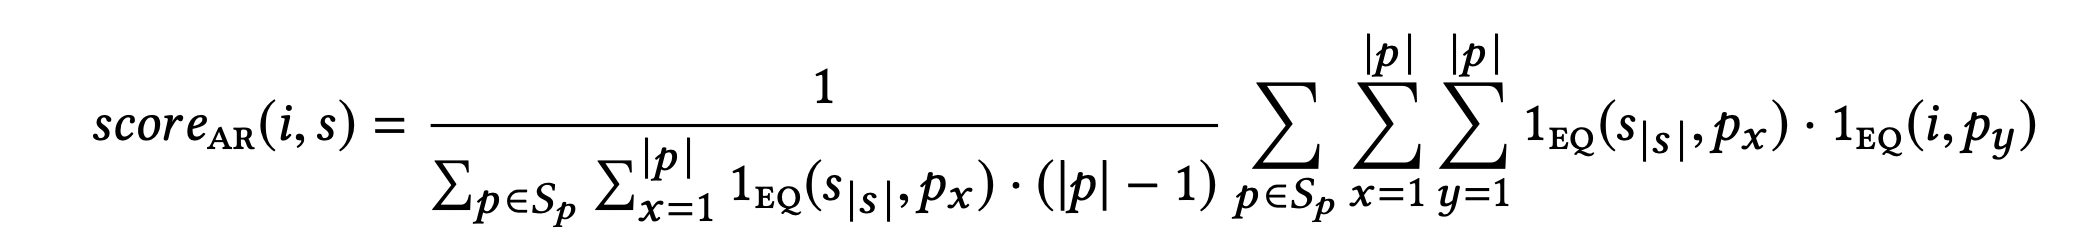



(mc) baseline can be seen as a variant of ar with a focus on
sequences in the data. Here, the rules are extracted from a first-order Markov Chain, which describes the transition probability between two subsequent events in a session. In
our baseline approach, we simply count how often users viewed item $q$ immediately after viewing
item $p$. Technically, the score for an item i given the current session $s$ with the last event $s_{|s|}$ can be
defined as: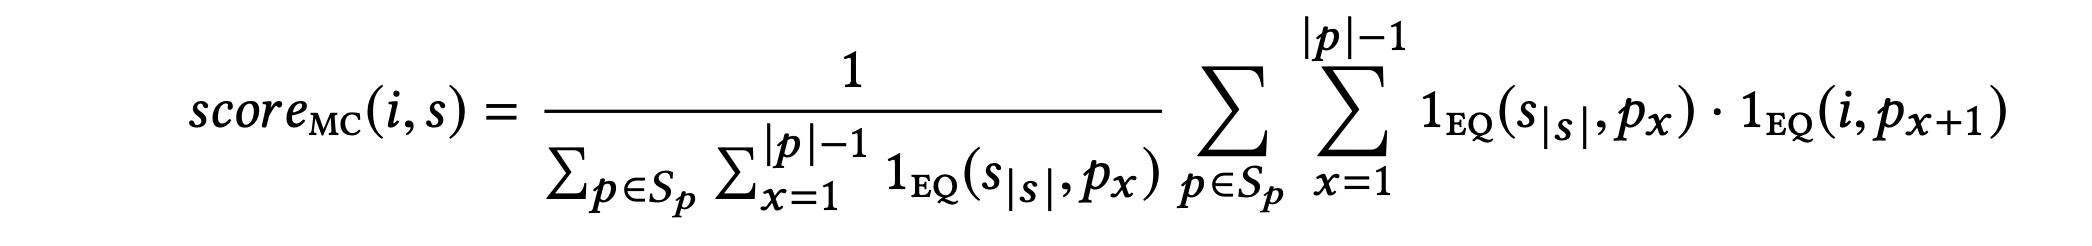

(sr) Finally, the sr method  is
a variation of mc or ar respectively. It also takes the order of actions into account, but in a less
restrictive manner. In contrast to the mc method, we create a rule when an item q appeared after
an item $p$ in a session even when other events happened between $p$ and $q$. When assigning weights to the rules, we consider the number of elements appearing between $p$
and $q$ in the session. Specifically, we use the weight function $w_{sr}(x) = 1/(x)$, where $x$ corresponds
to the number of steps between the two items. Given the current session $s$, the sr method calculates
the score for the target item $i$ as follows:
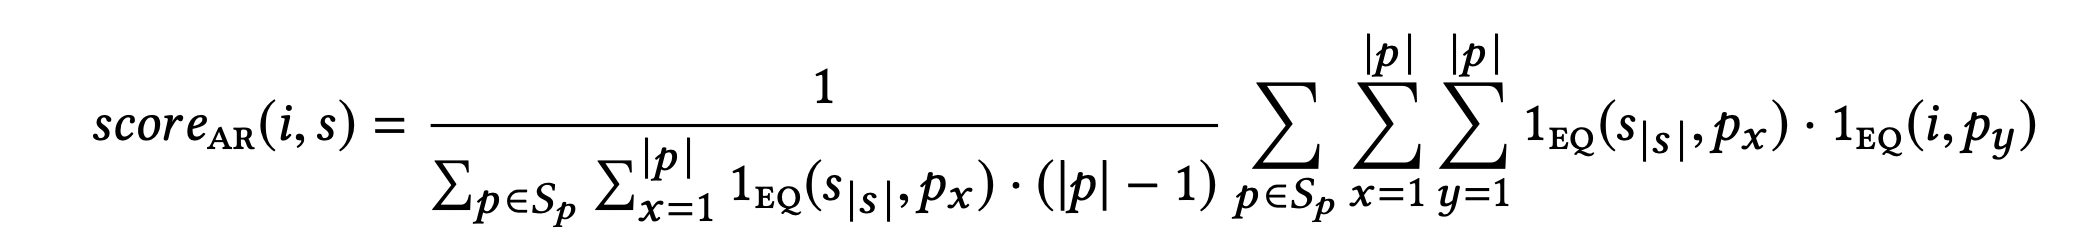

In [ ]:
class AssosiationRules:
    '''
    AssosiationRules(pruning=20, session_key='SessionId', item_key='ItemId')

    Parameters
    --------
    pruning : int
        Prune the results per item to a list of the top N co-occurrences. (Default value: 20)
    session_key : string
        The data frame key for the session identifier. (Default value: SessionId)
    item_key : string
        The data frame key for the item identifier. (Default value: ItemId)

    '''

    def __init__( self, pruning=20, session_key='SessionId', item_key='ItemId' ):
        self.pruning = pruning
        self.session_key = session_key
        self.item_key = item_key
        self.session = -1
        self.session_items = []

    def fit( self, data ):
        '''
        Trains the predictor.

        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).


        '''

        cur_session = -1
        last_items = []
        rules = dict()

        index_session = data.columns.get_loc( self.session_key )
        index_item = data.columns.get_loc( self.item_key )

        for row in data.itertuples( index=False ):

            session_id, item_id = row[index_session], row[index_item]

            if session_id != cur_session:
                cur_session = session_id
                last_items = []
            else:
                for item_id2 in last_items:

                    if not item_id in rules :
                        rules[item_id] = dict()

                    if not item_id2 in rules :
                        rules[item_id2] = dict()

                    if not item_id in rules[item_id2]:
                        rules[item_id2][item_id] = 0

                    if not item_id2 in rules[item_id]:
                        rules[item_id][item_id2] = 0

                    rules[item_id][item_id2] += 1
                    rules[item_id2][item_id] += 1

            last_items.append( item_id )

        if self.pruning > 0 :
            self.prune( rules )

        self.rules = rules

    def linear(self, i):
        return 1 - (0.1*i) if i <= 10 else 0

    def same(self, i):
        return 1

    def div(self, i):
        return 1/i

    def log(self, i):
        return 1/(log10(i+1.7))

    def quadratic(self, i):
        return 1/(i*i)

    def predict_next(self, session_id, input_item_id, predict_for_item_ids, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.

        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.

        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.

        '''
        if session_id != self.session:
            self.session_items = []
            self.session = session_id

        if type == 'view':
            self.session_items.append( input_item_id )

        if skip:
            return

        preds = np.zeros( len(predict_for_item_ids) )

        if input_item_id in self.rules:
            for key in self.rules[input_item_id]:
                preds[ predict_for_item_ids == key ] = self.rules[input_item_id][key]

        series = pd.Series(data=preds, index=predict_for_item_ids)

        series = series / series.max()

        return series

    def prune(self, rules):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
        Parameters
            --------
            rules : dict of dicts
                The rules mined from the training data
        '''
        for k1 in rules:
            tmp = rules[k1]
            if self.pruning < 1:
                keep = len(tmp) - int( len(tmp) * self.pruning )
            elif self.pruning >= 1:
                keep = self.pruning
            counter = col.Counter( tmp )
            rules[k1] = dict()
            for k2, v in counter.most_common( keep ):
                rules[k1][k2] = v

In [ ]:
class SequentialRules:
    '''
    SequentialRules(steps = 10, weighting='div', pruning=20.0, last_n_days=None, session_key='SessionId', item_key='ItemId', time_key='Time')

    Parameters
    --------
    steps : int
        Number of steps to walk back from the currently viewed item. (Default value: 10)
    weighting : string
        Weighting function for the previous items (linear, same, div, log, qudratic). (Default value: div)
    pruning : int
        Prune the results per item to a list of the top N sequential co-occurrences. (Default value: 20).
    last_n_days : int
        Only use the last N days of the data for the training process. (Default value: None)
    session_key : string
        The data frame key for the session identifier. (Default value: SessionId)
    item_key : string
        The data frame key for the item identifier. (Default value: ItemId)
    time_key : string
        The data frame key for the timestamp. (Default value: Time)

    '''

    def __init__( self, steps = 10, weighting='div', pruning=20, last_n_days=None, session_key='SessionId', item_key='ItemId', time_key='Time' ):
        self.steps = steps
        self.pruning = pruning
        self.weighting = weighting
        self.last_n_days = last_n_days
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.session = -1
        self.session_items = []

    def fit( self, data ):
        '''
        Trains the predictor.

        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).


        '''

        if self.last_n_days != None:

            max_time = datetime.fromtimestamp( data[self.time_key].max() )
            date_threshold = max_time.date() - timedelta( self.last_n_days )
            stamp = datetime.combine(date_threshold, datetime.min.time()).timestamp()
            train = data[ data[self.time_key] >= stamp ]

        else:
            train = data

        cur_session = -1
        last_items = []
        rules = dict()

        index_session = train.columns.get_loc( self.session_key )
        index_item = train.columns.get_loc( self.item_key )

        for row in train.itertuples( index=False ):

            session_id, item_id = row[index_session], row[index_item]

            if session_id != cur_session:
                cur_session = session_id
                last_items = []
            else:
                for i in range( 1, self.steps+1 if len(last_items) >= self.steps else len(last_items)+1 ):
                    prev_item = last_items[-i]

                    if not prev_item in rules :
                        rules[prev_item] = dict()

                    if not item_id in rules[prev_item]:
                        rules[prev_item][item_id] = 0

                    rules[prev_item][item_id] += getattr(self, self.weighting)( i )

            last_items.append(item_id)

        if self.pruning > 0 :
            self.prune( rules )

        self.rules = rules

    def linear(self, i):
        return 1 - (0.1*i) if i <= 100 else 0

    def same(self, i):
        return 1

    def div(self, i):
        return 1/i

    def log(self, i):
        return 1/(log10(i+1.7))

    def quadratic(self, i):
        return 1/(i*i)

    def predict_next(self, session_id, input_item_id, predict_for_item_ids, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.

        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.

        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.

        '''
        if session_id != self.session:
            self.session_items = []
            self.session = session_id

        if type == 'view':
            self.session_items.append( input_item_id )

        if skip:
            return

        preds = np.zeros( len(predict_for_item_ids) )

        if input_item_id in self.rules:
            for key in self.rules[input_item_id]:
                preds[ predict_for_item_ids == key ] = self.rules[input_item_id][key]

        #test
#         for i in range(2,4):
#             if len(self.session_items) >= i :
#                 item = self.session_items[-i]
#                 for key in self.rules[ item ]:
#                     preds[ predict_for_item_ids == key ] += self.rules[item][key] * (1/i)

        series = pd.Series(data=preds, index=predict_for_item_ids)

        series = series / series.max()

        return series

    def prune(self, rules):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
        Parameters
            --------
            rules : dict of dicts
                The rules mined from the training data
        '''
        for k1 in rules:
            tmp = rules[k1]
            if self.pruning < 1:
                keep = len(tmp) - int( len(tmp) * self.pruning )
            elif self.pruning >= 1:
                keep = self.pruning
            counter = col.Counter( tmp )
            rules[k1] = dict()
            for k2, v in counter.most_common( keep ):
                rules[k1][k2] = v

In [ ]:
class MarkovModel:
    '''
    MarkovModel( pruning=20, last_n_days=None, session_key='SessionId', item_key='ItemId', time_key='Time' )

    Parameters
    --------
    pruning : int
        Prune the results per item to a list of the top N sequential co-occurrences. (Default value: 20).
    last_n_days : int
        Only use the last N days of the data for the training process. (Default value: None)
    session_key : string
        The data frame key for the session identifier. (Default value: SessionId)
    item_key : string
        The data frame key for the item identifier. (Default value: ItemId)
    time_key : string
        The data frame key for the timestamp. (Default value: Time)

    '''

    def __init__( self, pruning=20, last_n_days=None, session_key='SessionId', item_key='ItemId', time_key='Time' ):
        self.pruning = pruning
        self.last_n_days = last_n_days
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.session = -1
        self.session_items = []

    def fit( self, data ):
        '''
        Trains the predictor.

        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).


        '''

        if self.last_n_days != None:

            max_time = datetime.fromtimestamp( data[self.time_key].max() )
            date_threshold = max_time.date() - timedelta( self.last_n_days )
            stamp = datetime.combine(date_threshold, datetime.min.time()).timestamp()
            train = data[ data[self.time_key] >= stamp ]

        else:
            train = data

        cur_session = -1
        prev_item = -1
        rules = dict()

        index_session = train.columns.get_loc( self.session_key )
        index_item = train.columns.get_loc( self.item_key )

        for row in train.itertuples( index=False ):

            session_id, item_id = row[index_session], row[index_item]

            if session_id != cur_session:
                cur_session = session_id
            else:
                if not prev_item in rules :
                    rules[prev_item] = dict()

                if not item_id in rules[prev_item]:
                    rules[prev_item][item_id] = 0

                rules[prev_item][item_id] += 1

            prev_item = item_id

        if self.pruning > 0 :
            self.prune( rules )

        self.rules = rules

    def predict_next(self, session_id, input_item_id, predict_for_item_ids, skip=False, type='view', timestamp=0):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.

        Parameters
        --------
        session_id : int or string
            The session IDs of the event.
        input_item_id : int or string
            The item ID of the event.
        predict_for_item_ids : 1D array
            IDs of items for which the network should give prediction scores. Every ID must be in the set of item IDs of the training set.

        Returns
        --------
        out : pandas.Series
            Prediction scores for selected items on how likely to be the next item of this session. Indexed by the item IDs.

        '''
        if session_id != self.session:
            self.session_items = []
            self.session = session_id

        if type == 'view':
            self.session_items.append( input_item_id )

        if skip:
            return

        preds = np.zeros( len(predict_for_item_ids) )

        if input_item_id in self.rules:
            for key in self.rules[input_item_id]:
                preds[ predict_for_item_ids == key ] = self.rules[input_item_id][key]

        #test
#         for i in range(2,4):
#             if len(self.session_items) >= i :
#                 item = self.session_items[-i]
#                 for key in self.rules[ item ]:
#                     preds[ predict_for_item_ids == key ] += self.rules[item][key] * (1/i)

        series = pd.Series(data=preds, index=predict_for_item_ids)

        series = series / series.max()

        return series

    def prune(self, rules):
        '''
        Gives predicton scores for a selected set of items on how likely they be the next item in the session.
        Parameters
            --------
            rules : dict of dicts
                The rules mined from the training data
        '''
        for k1 in rules:
            tmp = rules[k1]
            if self.pruning < 1:
                keep = len(tmp) - int( len(tmp) * self.pruning )
            elif self.pruning >= 1:
                keep = self.pruning
            counter = col.Counter( tmp )
            rules[k1] = dict()
            for k2, v in counter.most_common( keep ):
                rules[k1][k2] = v

In [ ]:
algs = {}
#baselines
mk = MarkovModel()
algs['markov'] = mk
sra = SequentialRules( 10, weighting='div', pruning=20, last_n_days=None )
algs['sr10-div'] = sra
ara = AssosiationRules()
algs['ar'] = ara


Finally, the three algorithms are implemented on the first slice of the dataset here.

In [ ]:
# load data
train, test = load_data_exec( data_path, file_prefix, rows_train=limit_train, rows_test=limit_test, slice_num = 1, density=density_value )

item_ids = train.ItemId.unique()

#init metrics
for m in metric:
    m.init( train )

#train algorithms
for k,a in algs.items():
    ts = time.time()
    print( "    fit ", k )
    a.fit( train )
    #print( k, ' time: ', ( time.time() - ts) )
    #print( k, ' memory: ', asizeof.asizeof(a) )

START load data
Loaded train set
	Events: 212266
	Sessions: 57795
	Items: 32529
	Span: 2015-05-30 / 2015-06-24

Loaded test set
	Events: 15425
	Sessions: 4260
	Items: 6801
	Span: 2015-06-24 / 2015-06-26

END load data  0.10837196999999321 c /  0.12372803688049316 s
    fit  markov
    fit  sr10-div
    fit  ar


And the test results are calculated finally here:

In [ ]:
#result dict
res = {};

#evaluation
for k, a in algs.items():
    res[k] = evaluate_sessions( a, metric, test, train )

#print results
for k, l in res.items():
    for e in l:
        print( k, ':', e[0], ' ', e[1] )


START evaluation of  15425  actions in  4260  sessions
    eval process:  0  of  15425  actions:  0.0  % in 0.009468793869018555 s
    eval process:  1000  of  15425  actions:  6.482982171799027  % in 3.536039352416992 s
    eval process:  2000  of  15425  actions:  12.965964343598054  % in 6.708797216415405 s
    eval process:  3000  of  15425  actions:  19.448946515397083  % in 9.29426097869873 s
    eval process:  4000  of  15425  actions:  25.93192868719611  % in 12.017468690872192 s
    eval process:  5000  of  15425  actions:  32.414910858995135  % in 14.62607717514038 s
    eval process:  6000  of  15425  actions:  38.897893030794165  % in 18.802364826202393 s
    eval process:  7000  of  15425  actions:  45.38087520259319  % in 21.48926281929016 s
    eval process:  8000  of  15425  actions:  51.86385737439222  % in 24.23783540725708 s
    eval process:  9000  of  15425  actions:  58.34683954619124  % in 27.1238911151886 s
    eval process:  10000  of  15425  actions:  64.82982